In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pyproj
from sea_breeze import load_model_data
from dask.distributed import Client

geod = pyproj.Geod(ellps="WGS84")
def calc_dist(lon1,lat1,lon2,lat2):
    fa,_,d = geod.inv(lon1,lat1,lon2,lat2)
    return d/1e3

def get_weights(x,R1):
    return np.where(x <= R1,
               0.75 - 0.5*(x/R1)**2,
               0.25*np.power(x/R1,-4))

def get_x(angle_ds,coastal=True):

    lon,lat = get_coast_latlon(angle_ds,coastal)
    xc, yc = np.where(angle_ds.coast == 1)
    lons, lats = np.meshgrid(angle_ds.lon, angle_ds.lat)
    lonc = lons[xc,yc]
    latc = lats[xc,yc]

    return np.sort(calc_dist(lonc*0+lon,latc*0+lat,lonc,latc))

def get_coast_latlon(angle_ds,coastal):

    if coastal:
        c_y, c_x = np.where(angle_ds.coast==1)
        return (angle_ds.isel(lon=c_x[0],lat=c_y[0]).lon.values,
                angle_ds.isel(lon=c_x[0],lat=c_y[0]).lat.values)
    else:
        c_y = (np.abs((angle_ds.min_coast_dist - 100))).argmin(("lat","lon"))["lat"].values
        c_x = (np.abs((angle_ds.min_coast_dist - 100))).argmin(("lat","lon"))["lon"].values
        return (angle_ds.isel(lon=c_x,lat=c_y).lon.values,
                angle_ds.isel(lon=c_x,lat=c_y).lat.values)
    
    

In [3]:
angle_ds_era5 = xr.open_dataset("/g/data/ng72/ab4502/coastline_data/era5.nc")
angle_ds_barra_r = xr.open_dataset("/g/data/ng72/ab4502/coastline_data/barra_r.nc")
angle_ds_barra_c = xr.open_dataset("/g/data/ng72/ab4502/coastline_data/barra_c.nc")
angle_ds_aus2200 = xr.open_dataset("/g/data/ng72/ab4502/coastline_data/aus2200.nc")

/jobfs/141467138.gadi-pbs/ipykernel_371815/568188935.py:17: RuntimeWarning: divide by zero encountered in power
  0.25*np.power(x/R1,-4))


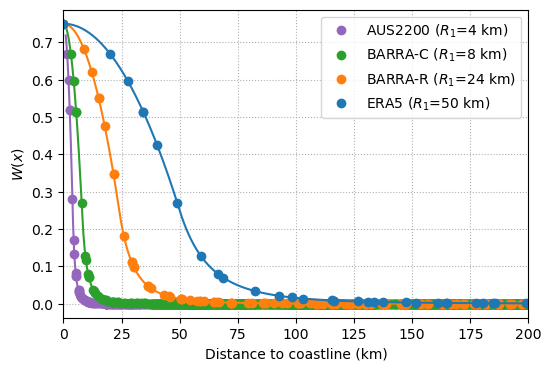

In [4]:
x = np.linspace(1,200,1000)
era5_x = get_x(angle_ds_era5)
barra_r_x = get_x(angle_ds_barra_r)
barra_c_x = get_x(angle_ds_barra_c)
aus2200_x = get_x(angle_ds_aus2200)

plt.figure(figsize=[6,4])

plt.plot(x,get_weights(x,R1=4),marker="none",color="tab:purple")
plt.plot(aus2200_x,get_weights(aus2200_x,R1=4),marker="o",ls="none",color="tab:purple",label="AUS2200 ($R_1$=4 km)")

plt.plot(x,get_weights(x,R1=8),marker="none",color="tab:green")
plt.plot(barra_c_x,get_weights(barra_c_x,R1=8),marker="o",ls="none",color="tab:green",label="BARRA-C ($R_1$=8 km)")

plt.plot(x,get_weights(x,R1=24),marker="none",color="tab:orange")
plt.plot(barra_r_x,get_weights(barra_r_x,R1=24),marker="o",ls="none",color="tab:orange",label="BARRA-R ($R_1$=24 km)")

plt.plot(x,get_weights(x,R1=50),marker="none",color="tab:blue")
plt.plot(era5_x,get_weights(era5_x,R1=50),marker="o",ls="none",color="tab:blue",label="ERA5 ($R_1$=50 km)")


plt.xlim([0,200])

plt.legend()

plt.gca().grid(ls=":")

plt.xlabel("Distance to coastline (km)")
plt.ylabel("$W(x)$")

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/weighting.jpeg",dpi=400,bbox_inches="tight")

In [6]:
#Initiate distributed dask client on the Gadi HPC
client = Client()

#This slice is the outer bounds of the AUS2200 domain
lon_slice = slice(142,150)
lat_slice = slice(-45,-39)       

_, lsm = load_model_data.load_barra_static("AUST-04",lon_slice,lat_slice)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37999 instead
  warnings.warn(


In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37999/status,
Dashboard: /proxy/37999/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45321,Workers: 7
Dashboard: /proxy/37999/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:34427,Total threads: 1
Dashboard: /proxy/38647/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:34219,


In [8]:
angles8 = load_model_data.get_coastline_angle_kernel(
    lsm,
    R=8,
    compute=True,
    latlon_chunk_size=100,
    save=False)

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...
INFO: Calculating the sum of the weights...
INFO: Calculating variance...
INFO: Calculating minimum distance to the coast...


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

In [9]:
angles100 = load_model_data.get_coastline_angle_kernel(
    lsm,
    R=100,
    compute=True,
    latlon_chunk_size=100,
    save=False)

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...
INFO: Calculating the sum of the weights...
INFO: Calculating variance...
INFO: Calculating minimum distance to the coast...


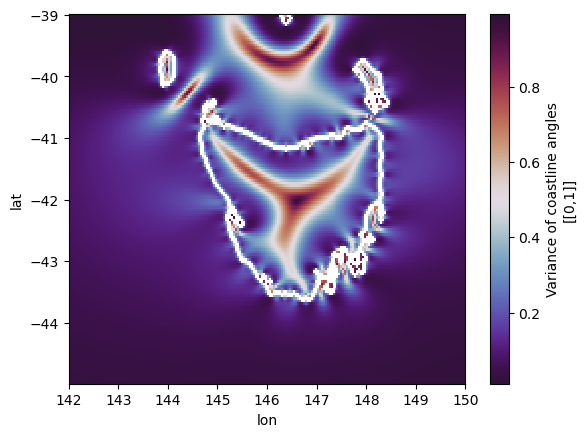

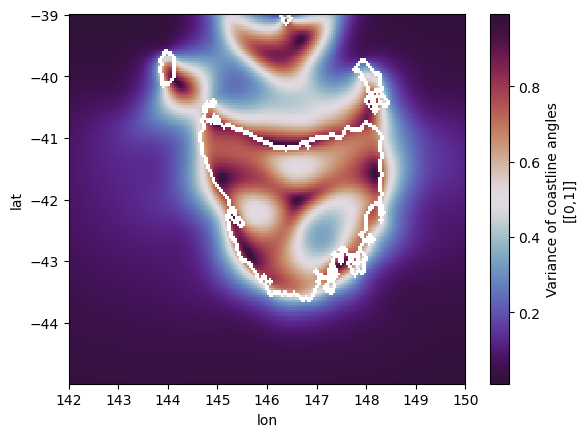

In [10]:
plt.figure()
angles8.variance.plot(cmap="twilight_shifted")

plt.figure()
angles100.variance.plot(cmap="twilight_shifted")

In [5]:
lon_slice = slice(108,159)
lat_slice = slice(-45.7,-6.831799)       

_, era5_lsm, cl = load_model_data.load_era5_static(lon_slice,lat_slice,"2016-01-01 00:00","2016-01-01 00:00")
era5_lsm = load_model_data.remove_era5_inland_lakes(era5_lsm,cl)
_, aus2200_lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)

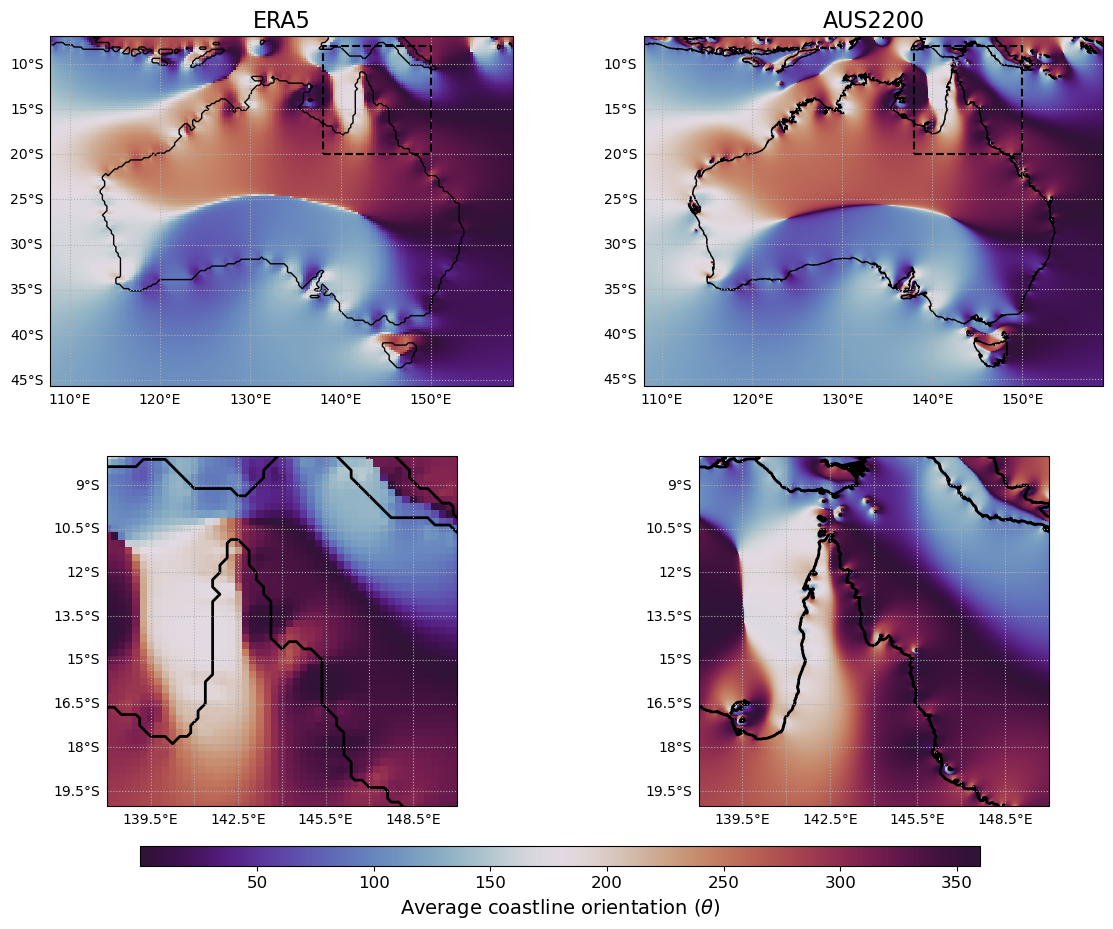

In [16]:
plt.figure(figsize=[14,10])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
angle_ds_era5.angle_interp.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contour(
    era5_lsm,
    levels=1,
    colors="k",
    linewidths=1)
ax.gridlines(ls=":",draw_labels=["bottom","left"])
plt.title("ERA5",size=16)
plt.plot([138,150,150,138,138],[-20,-20,-8,-8,-20], ls="--", color="k")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
angle_ds_aus2200.angle_interp.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contour(
    aus2200_lsm,
    levels=1,
    colors="k",
    linewidths=1)
ax.gridlines(ls=":",draw_labels=["bottom","left"])
plt.title("AUS2200",size=16)
plt.plot([138,150,150,138,138],[-20,-20,-8,-8,-20], ls="--", color="k")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
angle_ds_era5.angle_interp.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contour(
    era5_lsm,
    levels=1,
    colors="k",
    linewidths=2)
plt.xlim([138,150])
plt.ylim([-20,-8])
ax.gridlines(ls=":",draw_labels=["bottom","left"])
plt.title("")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
c=angle_ds_aus2200.angle_interp.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contour(
    aus2200_lsm,
    levels=1,
    colors="k",
    linewidths=2)
plt.xlim([138,150])
plt.ylim([-20,-8])
ax.gridlines(ls=":",draw_labels=["bottom","left"])
plt.title("")

cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Average coastline orientation $({\\theta})$",size=14)
cb.ax.tick_params(labelsize=12)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/angles.jpeg",dpi=400,bbox_inches="tight")

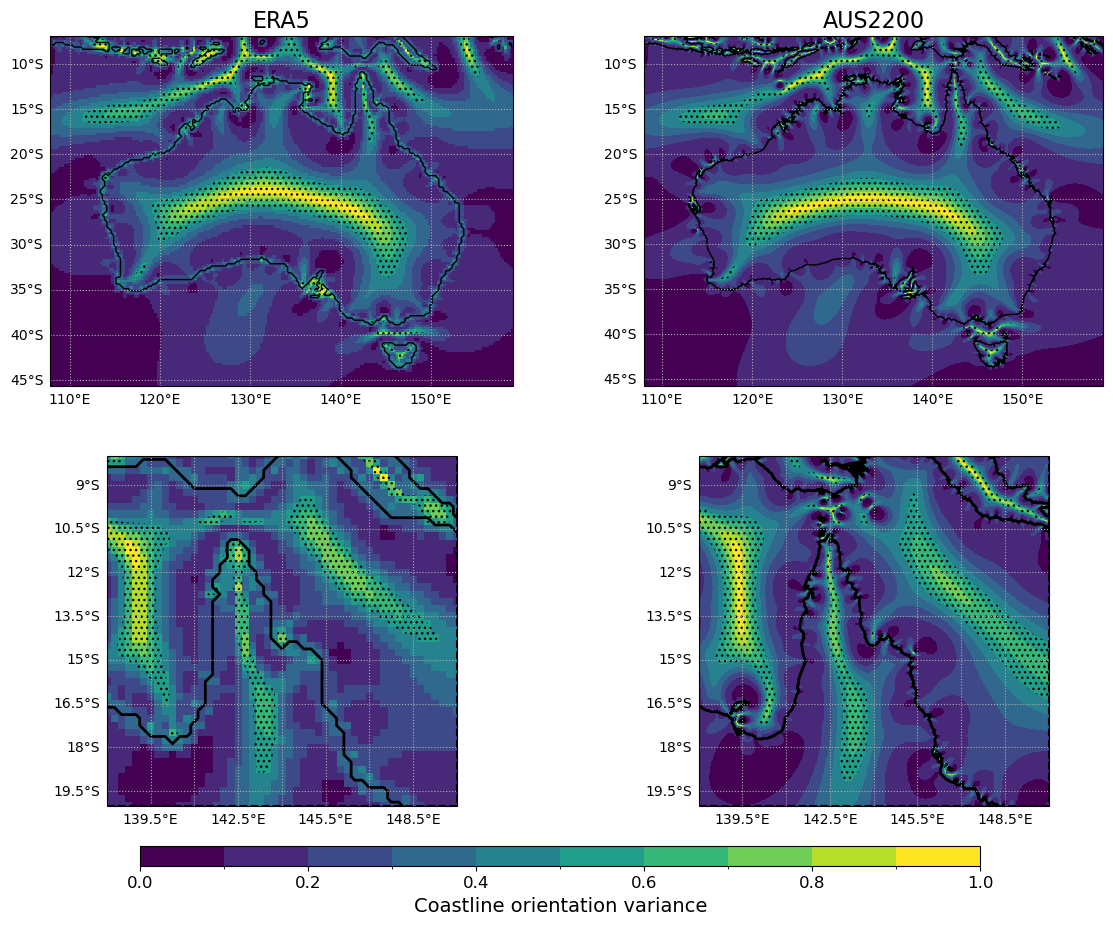

In [19]:
plt.figure(figsize=[14,10])

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
angle_ds_era5.variance_interp.plot(levels=np.linspace(0,1,11),add_colorbar=False)
xr.plot.contour(
    era5_lsm,
    levels=1,
    colors="k",
    linewidths=2)
xr.plot.contourf(
    angle_ds_era5.variance_interp,
    ax=ax,
    levels=[0.5,1],
    extend="neither",
    colors=["none"],
    alpha=0,
    hatches=["..."],
    add_colorbar=False)
plt.xlim([138,150])
plt.ylim([-20,-8])
ax.gridlines(ls=":",draw_labels=["bottom","left"])
plt.plot([138,150,150,138,138],[-20,-20,-8,-8,-20], ls="--", color="k")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
angle_ds_aus2200.variance_interp.plot(levels=np.linspace(0,1,11),add_colorbar=False)
xr.plot.contour(
    aus2200_lsm,
    levels=1,
    colors="k",
    linewidths=2)
xr.plot.contourf(
    angle_ds_aus2200.variance_interp,
    ax=ax,
    levels=[0.5,1],
    extend="neither",
    colors=["none"],
    alpha=0,
    hatches=["..."],
    add_colorbar=False)
plt.xlim([138,150])
plt.ylim([-20,-8])
ax.gridlines(ls=":",draw_labels=["bottom","left"])
plt.plot([138,150,150,138,138],[-20,-20,-8,-8,-20], ls="--", color="k")

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
angle_ds_era5.variance_interp.plot(levels=np.linspace(0,1,11),add_colorbar=False)
xr.plot.contour(
    era5_lsm,
    levels=1,
    colors="k",
    linewidths=1)
xr.plot.contourf(
    angle_ds_era5.variance_interp,
    levels=[0.5,1],
    extend="neither",
    colors=["none"],
    alpha=0,
    hatches=["..."],
    add_colorbar=False)
ax.gridlines(ls=":",draw_labels=["bottom","left"])
plt.title("ERA5",size=16)

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
c=angle_ds_aus2200.variance_interp.plot(levels=np.linspace(0,1,11),add_colorbar=False)
xr.plot.contour(
    aus2200_lsm,
    levels=1,
    colors="k",
    linewidths=1)
xr.plot.contourf(
    angle_ds_aus2200.variance_interp,
    levels=[0.5,1],
    extend="neither",
    colors=["none"],
    alpha=0,
    hatches=["..."],
    add_colorbar=False)
ax.gridlines(ls=":",draw_labels=["bottom","left"])
plt.title("AUS2200",size=16)

cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Coastline orientation variance",size=14)
cb.ax.tick_params(labelsize=12)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/variance.jpeg",dpi=400,bbox_inches="tight")